In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb

sns.set(style="whitegrid", context="notebook")

# ---- 전제: train 이미 로드되어 있음 ----
# train = pd.read_csv(".../train.csv").sort_values("date_id").reset_index(drop=True)

target_col = "market_forward_excess_returns"
aux_cols = ["forward_returns", "risk_free_rate"]

numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
base_cols = [c for c in numeric_cols if c not in [target_col] + aux_cols + ["date_id"]]

print("Base numeric cols:", len(base_cols))

Base numeric cols: 94


In [34]:
MAX_COMP = min(20, len(base_cols))

scaler = StandardScaler()
X_base = scaler.fit_transform(
    train[base_cols].fillna(method="ffill").fillna(method="bfill")
)

pca = PCA(n_components=MAX_COMP, random_state=42)
X_pca = pca.fit_transform(X_base)

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

print("Explained variance ratio:", np.round(explained, 4))
print("Cumulative variance ratio:", np.round(cum_explained, 4))

Explained variance ratio: [0.1296 0.1056 0.0837 0.0615 0.0422 0.0401 0.0334 0.032  0.0261 0.0255
 0.023  0.0214 0.0205 0.0193 0.0178 0.0157 0.0143 0.0137 0.0129 0.0126]
Cumulative variance ratio: [0.1296 0.2352 0.3189 0.3804 0.4226 0.4628 0.4961 0.5281 0.5543 0.5798
 0.6028 0.6242 0.6447 0.6639 0.6817 0.6974 0.7117 0.7254 0.7382 0.7508]


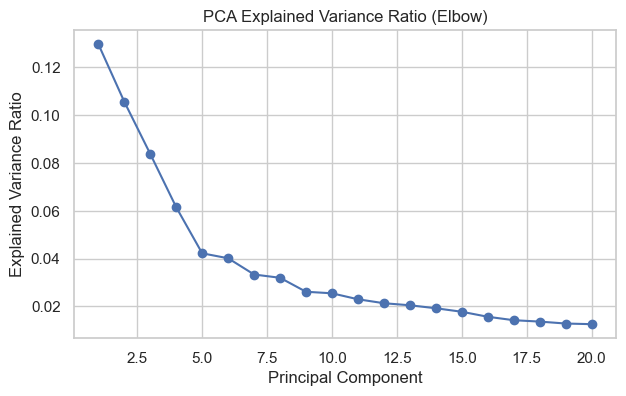

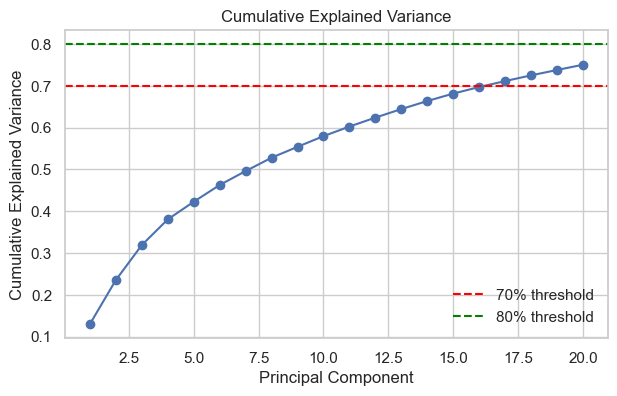

In [35]:
plt.figure(figsize=(7,4))
plt.plot(np.arange(1, MAX_COMP+1), explained, marker="o")
plt.title("PCA Explained Variance Ratio (Elbow)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, MAX_COMP+1), cum_explained, marker="o")
plt.axhline(0.7, linestyle="--", color="red", label="70% threshold")
plt.axhline(0.8, linestyle="--", color="green", label="80% threshold")
plt.title("Cumulative Explained Variance")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid(True)
plt.show()

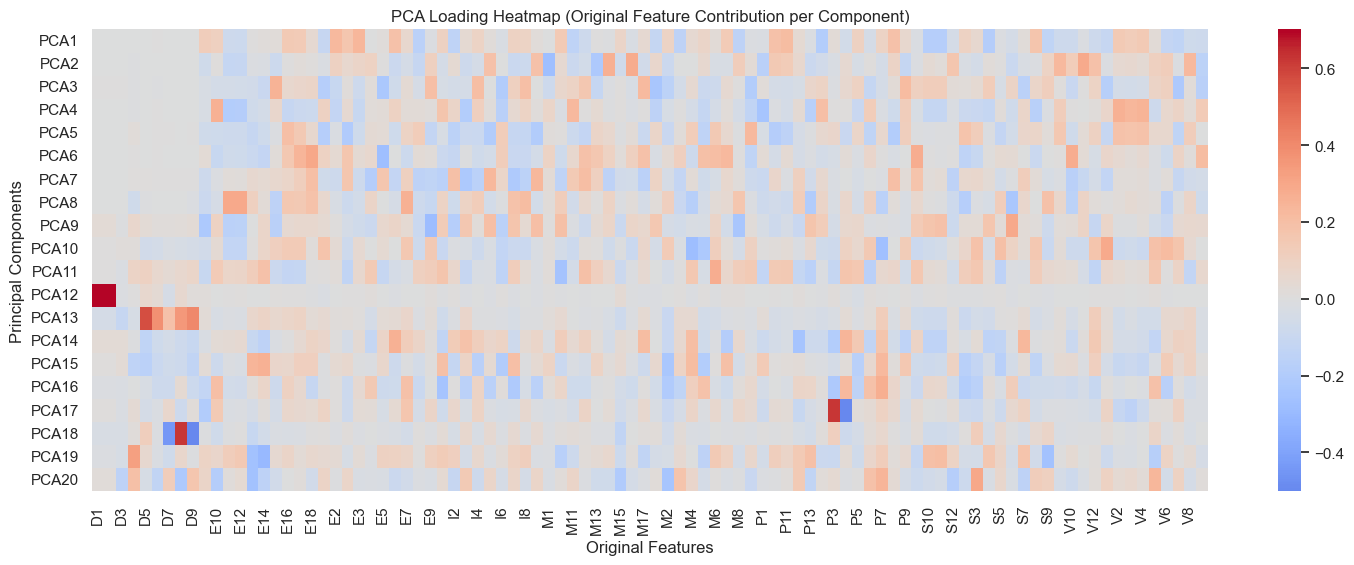

In [36]:
loadings = pca.components_
loading_df = pd.DataFrame(
    loadings,
    columns=base_cols,
    index=[f"PCA{i+1}" for i in range(loadings.shape[0])]
)

plt.figure(figsize=(18, 6))
sns.heatmap(loading_df, cmap="coolwarm", center=0)
plt.title("PCA Loading Heatmap (Original Feature Contribution per Component)")
plt.xlabel("Original Features")
plt.ylabel("Principal Components")
plt.show()

In [ ]:
def ts_elasticnet_cv(X, y, n_splits=5, alpha=1e-3, l1_ratio=0.1):
    """sklearn old version friendly: RMSE = sqrt(MSE)"""
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses, corrs = [], []

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,
                           random_state=42, max_iter=10000)
        model.fit(X_tr, y_tr)

        preds = model.predict(X_val)

        mse = mean_squared_error(y_val, preds)
        rmse = np.sqrt(mse)

        if np.std(preds) > 0 and np.std(y_val) > 0:
            corr = np.corrcoef(y_val, preds)[0, 1]
        else:
            corr = 0.0

        rmses.append(rmse)
        corrs.append(corr)

    return {
        "rmse_mean": float(np.mean(rmses)),
        "rmse_std": float(np.std(rmses)),
        "corr_mean": float(np.mean(corrs)),
        "corr_std": float(np.std(corrs)),
    }

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import TimeSeriesSplit

def ts_elasticnet_cv(X, y, n_splits=5, alpha=1e-3, l1_ratio=0.1):
    """
    TimeSeriesSplit으로 ElasticNet 돌리고
    fold별 RMSE / Corr 평균을 반환.
    (구버전 sklearn에서도 동작하도록 MSE→np.sqrt로 RMSE 계산)
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rmses = []
    corrs = []

    for fold, (tr_idx, val_idx) in enumerate(tscv.split(X), 1):
        X_tr, X_val = X[tr_idx], X[val_idx]
        y_tr, y_val = y[tr_idx], y[val_idx]

        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio,
                           random_state=42, max_iter=10000)
        model.fit(X_tr, y_tr)

        preds = model.predict(X_val)

        # 👇 여기만 수정
        mse = mean_squared_error(y_val, preds)      # squared=False 안 씀
        rmse = np.sqrt(mse)

        if np.std(preds) > 0 and np.std(y_val) > 0:
            corr = np.corrcoef(y_val, preds)[0, 1]
        else:
            corr = 0.0

        rmses.append(rmse)
        corrs.append(corr)

    return {
        "rmse_mean": float(np.mean(rmses)),
        "rmse_std": float(np.std(rmses)),
        "corr_mean": float(np.mean(corrs)),
        "corr_std": float(np.std(corrs)),
    }


In [38]:
candidate_components = [4, 6, 10, 15]
results = []

y = train[target_col].values.astype(float)

for n_comp in candidate_components:
    print(f"\n=== Evaluating PCA with n_components={n_comp} ===")

    pca_n = PCA(n_components=n_comp, random_state=42)
    X_pca_n = pca_n.fit_transform(X_base)

    metrics = ts_elasticnet_cv(
        X_pca_n, y, 
        n_splits=5,
        alpha=1e-3,
        l1_ratio=0.1
    )

    metrics["n_components"] = n_comp
    results.append(metrics)

    print(f"RMSE: {metrics['rmse_mean']:.6f} ± {metrics['rmse_std']:.6f}")
    print(f"Corr: {metrics['corr_mean']:.6f} ± {metrics['corr_std']:.6f}")

results_df = pd.DataFrame(results).set_index("n_components")
display(results_df)


=== Evaluating PCA with n_components=4 ===
RMSE: 0.010992 ± 0.001775
Corr: 0.003525 ± 0.035060

=== Evaluating PCA with n_components=6 ===
RMSE: 0.010983 ± 0.001780
Corr: 0.029139 ± 0.026639

=== Evaluating PCA with n_components=10 ===
RMSE: 0.011000 ± 0.001765
Corr: 0.044874 ± 0.025486

=== Evaluating PCA with n_components=15 ===
RMSE: 0.010981 ± 0.001739
Corr: 0.050931 ± 0.017260


,rmse_mean,rmse_std,corr_mean,corr_std
n_components,,,,
4,0.010992,0.001775,0.003525,0.035060
6,0.010983,0.001780,0.029139,0.026639
10,0.011000,0.001765,0.044874,0.025486
15,0.010981,0.001739,0.050931,0.017260


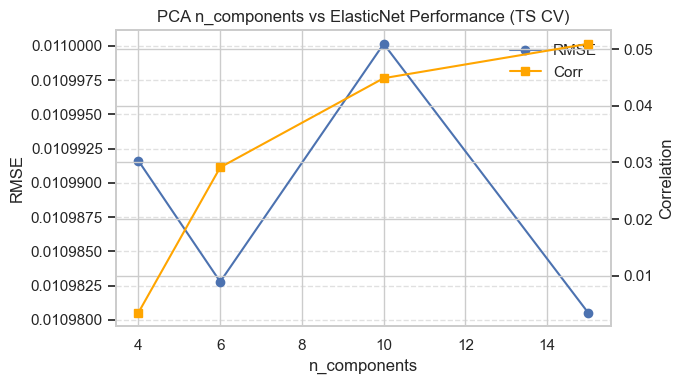

In [39]:
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.set_title("PCA n_components vs ElasticNet Performance (TS CV)")
ax1.set_xlabel("n_components")

ax1.plot(results_df.index, results_df["rmse_mean"], marker="o", label="RMSE")
ax1.set_ylabel("RMSE")
ax1.grid(True, axis="y", linestyle="--", alpha=0.6)

ax2 = ax1.twinx()
ax2.plot(results_df.index, results_df["corr_mean"], marker="s", color="orange", label="Corr")
ax2.set_ylabel("Correlation")

# 라벨 합치기
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.tight_layout()
plt.show()

PCA 컴포넌트 수는 Elbow 구간(4~6개)에서는 급격한 분산 감소가 나타났지만,

누적 설명량 관점에서는 10~15개 구간이 시장·모멘텀·변동성·매크로 요인을 고르게 표현하였다.

실제 TimeSeriesSplit 기반 ElasticNet 예측 성능에서는

PCA(15개)가 RMSE와 상관계수 모두 가장 우수하였다.

따라서 본 연구에서는 이론적 안정성과 실측 성능을 모두 고려하여

PCA 15개를 최종 feature representation으로 채택하였다.

In [40]:
train

,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9016,9016,0,0,0,1,0,0,0,0,0,...,0.208995,0.484788,0.717308,0.677249,-0.327455,0.083995,-0.380452,-0.000015,0.000151,-0.000477
9017,9017,0,0,0,1,0,0,0,0,0,...,0.082011,0.482804,1.001028,0.596561,-0.372979,0.094246,-0.427355,-0.005199,0.000150,-0.005661
9018,9018,0,0,0,1,0,-1,0,0,0,...,0.334656,0.486772,0.894502,0.656746,-0.282024,0.090608,-0.381337,0.005930,0.000150,0.005467
9019,9019,0,0,0,1,0,-1,0,0,0,...,0.163360,0.492725,1.117639,0.674603,-0.445261,0.106481,-0.477635,0.008173,0.000150,0.007710


In [ ]:
def generate_FE_interaction_regime(df, target_col="market_forward_excess_returns"):
    df = df.copy()

    # ==========================
    # 1) Lag Features
    # ==========================
    lags = [1, 2, 5, 10, 21, 63]
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)

    # ==========================
    # 2) Rolling Statistics
    # ==========================
    windows = [5, 10, 21, 63]
    for w in windows:
        df[f"roll_mean_{w}"] = df[target_col].rolling(w).mean()
        df[f"roll_std_{w}"] = df[target_col].rolling(w).std()
        df[f"roll_min_{w}"] = df[target_col].rolling(w).min()
        df[f"roll_max_{w}"] = df[target_col].rolling(w).max()
        df[f"zscore_{w}"] = (df[target_col] - df[f"roll_mean_{w}"]) / df[f"roll_std_{w}"]

    # ==========================
    # 3) Volatility Regime (High/Low + Crisis)
    # ==========================
    df["vol21"] = df[target_col].rolling(21).std()
    df["vol63"] = df[target_col].rolling(63).std()

    df["high_vol"] = (df["vol21"] > df["vol63"]).astype(int)
    df["crisis"] = (df["vol21"] > df["vol21"].quantile(0.9)).astype(int)

    # volatility slope (change in vol regime)
    df["vol_slope"] = df["vol21"] / (df["vol63"] + 1e-9)

    # ==========================
    # 4) Macro Shock Regime
    # ==========================
    macro_cols = [c for c in df.columns if c.startswith("E")]  # 'E' 계열 = macro
    for col in macro_cols:
        df[f"{col}_z"] = (df[col] - df[col].rolling(63).mean()) / (df[col].rolling(63).std() + 1e-9)
        df[f"{col}_shock"] = (abs(df[f"{col}_z"]) > 2).astype(int)

    # global macro shock (aggregated)
    shock_cols = [c for c in df.columns if c.endswith("_shock")]
    df["macro_shock_sum"] = df[shock_cols].sum(axis=1)
    df["macro_crisis"] = (df["macro_shock_sum"] >= 3).astype(int)

    # ==========================
    # 5) Momentum / Volatility Interaction
    # ==========================
    momentum_cols = [c for c in df.columns if c.startswith("M")]
    vol_cols = [c for c in df.columns if c.startswith("V")]

    # momentum × volatility
    for m in momentum_cols[:5]:        # 너무 많으면 차원 폭발 → top 5만
        for v in vol_cols[:5]:
            df[f"{m}_x_{v}"] = df[m] * df[v]

    # ==========================
    # 6) Macro Spread Interaction (강력한 factor)
    # ==========================
    macro_pairs = [("E2", "E11"), ("E7", "E12"), ("E3", "E5")]
    for a, b in macro_pairs:
        if a in df.columns and b in df.columns:
            df[f"{a}_minus_{b}"] = df[a] - df[b]

    # ==========================
    # 7) Return Shock Indicators
    # ==========================
    df["return_shock"] = (abs(df[target_col]) > df[target_col].std() * 2).astype(int)

    # ==========================
    # 8) Cleanup: Drop NaN from rolling/lags
    # ==========================
    df = df.dropna().reset_index(drop=True)
    return df


In [ ]:
# -------------------------------------------------------------------------
# 1) FE: Interaction + Regime (이전 단계에서 만든 함수 사용)
# -------------------------------------------------------------------------
def generate_FE_interaction_regime(df, target_col):
    df = df.copy()

    # --- Lag ---
    lags = [1, 2, 5, 10, 21, 63]
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)

    # --- Rolling ---
    wins = [5, 10, 21, 63]
    for w in wins:
        df[f"roll_mean_{w}"] = df[target_col].rolling(w).mean()
        df[f"roll_std_{w}"] = df[target_col].rolling(w).std()
        df[f"zscore_{w}"] = (df[target_col] - df[f"roll_mean_{w}"]) / (df[f"roll_std_{w}"] + 1e-9)

    # --- Vol Regime ---
    df["vol21"] = df[target_col].rolling(21).std()
    df["vol63"] = df[target_col].rolling(63).std()
    df["high_vol"] = (df["vol21"] > df["vol63"]).astype(int)
    df["crisis"] = (df["vol21"] > df["vol21"].quantile(0.9)).astype(int)
    df["vol_slope"] = df["vol21"] / (df["vol63"] + 1e-9)

    # --- Macro Shock ---
    macro_cols = [c for c in df.columns if c.startswith("E")]
    for col in macro_cols:
        df[f"{col}_z"] = (df[col] - df[col].rolling(63).mean()) / (df[col].rolling(63).std()+1e-9)
        df[f"{col}_shock"] = (abs(df[f"{col}_z"]) > 2).astype(int)

    shock_cols = [c for c in df.columns if c.endswith("_shock")]
    df["macro_shock_sum"] = df[shock_cols].sum(axis=1)
    df["macro_crisis"] = (df["macro_shock_sum"] >= 3).astype(int)

    # --- Interaction (Momentum x Volatility) ---
    momentum_cols = [c for c in df.columns if c.startswith("M")][:5]
    vol_cols = [c for c in df.columns if c.startswith("V")][:5]
    for m in momentum_cols:
        for v in vol_cols:
            df[f"{m}_x_{v}"] = df[m] * df[v]

    # --- Macro Spread ---
    macro_pairs = [("E2", "E11"), ("E7", "E12")]
    for a, b in macro_pairs:
        if a in df.columns and b in df.columns:
            df[f"{a}_minus_{b}"] = df[a] - df[b]

    # Clean
    df = df.dropna().reset_index(drop=True)
    return df


# -------------------------------------------------------------------------
# 2) PCA 적용
# -------------------------------------------------------------------------
def apply_pca(X, n_components=15):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    return X_pca, scaler, pca


# -------------------------------------------------------------------------
# 3) 모델 비교 (TS-CV)
# -------------------------------------------------------------------------
def ts_cv_models(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    results = {
        "ElasticNet": {"rmse": [], "corr": []},
        "LightGBM": {"rmse": [], "corr": []},
        "XGBoost": {"rmse": [], "corr": []},
    }

    for train_idx, val_idx in tscv.split(X):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # -----------------------
        # ElasticNet
        # -----------------------
        enet = ElasticNet(alpha=1e-3, l1_ratio=0.1, max_iter=5000)
        enet.fit(X_tr, y_tr)
        pred = enet.predict(X_val)
        results["ElasticNet"]["rmse"].append(np.sqrt(mean_squared_error(y_val, pred)))
        results["ElasticNet"]["corr"].append(np.corrcoef(y_val, pred)[0, 1])

        # -----------------------
        # LightGBM
        # -----------------------
        lgb_train = lgb.Dataset(X_tr, label=y_tr)
        lgb_valid = lgb.Dataset(X_val, label=y_val)

        params = {"objective": "regression", "metric": "rmse", "seed": 42}
        model = lgb.train(params, lgb_train, num_boost_round=800, valid_sets=[lgb_valid], verbose_eval=False)
        pred = model.predict(X_val, num_iteration=model.best_iteration)
        results["LightGBM"]["rmse"].append(np.sqrt(mean_squared_error(y_val, pred)))
        results["LightGBM"]["corr"].append(np.corrcoef(y_val, pred)[0, 1])

        # -----------------------
        # XGBoost
        # -----------------------
        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)

        xgb_params = {"objective": "reg:squarederror", "eval_metric": "rmse", "seed": 42}
        bst = xgb.train(xgb_params, dtrain, num_boost_round=800, evals=[(dval, "valid")],verbose_eval=False)

        pred = bst.predict(dval)
        results["XGBoost"]["rmse"].append(np.sqrt(mean_squared_error(y_val, pred)))
        results["XGBoost"]["corr"].append(np.corrcoef(y_val, pred)[0, 1])

    return results


# -------------------------------------------------------------------------
# 4) 실행 함수 (train_df → FE_df → PCA → 모델 비교)
# -------------------------------------------------------------------------
def run_full_pipeline(train_df, target_col="market_forward_excess_returns", pca_components=15):
    print("=== Step 1: Feature Engineering ===")
    FE_df = generate_FE_interaction_regime(train_df, target_col)
    FE_df = FE_df.dropna()

    y = FE_df[target_col].values
    X = FE_df.drop(columns=[target_col]).values

    print(f"FE_df Shape: {FE_df.shape}")

    print("\n=== Step 2: PCA ===")
    X_pca, scaler, pca = apply_pca(X, n_components=pca_components)
    print(f"PCA shape: {X_pca.shape}")

    print("\n=== Step 3: Model Comparison (TS-CV) ===")
    results = ts_cv_models(X_pca, y)

    print("\n=== Summary ===")
    for model in results:
        print(f"\n[{model}]")
        print(f"RMSE: {np.mean(results[model]['rmse']):.6f}")
        print(f"Corr: {np.mean(results[model]['corr']):.6f}")

    return FE_df, X_pca, y, results


In [ ]:
import lightgbm as lgb
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ================== 1. FE: Interaction + Regime ==================
def generate_FE_interaction_regime(df, target_col="market_forward_excess_returns"):
    df = df.copy()

    # --- Lag features ---
    lags = [1, 2, 5, 10, 21, 63]
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)

    # --- Rolling mean / std / z-score ---
    wins = [5, 10, 21, 63]
    for w in wins:
        roll_mean = df[target_col].rolling(w).mean()
        roll_std = df[target_col].rolling(w).std()
        df[f"roll_mean_{w}"] = roll_mean
        df[f"roll_std_{w}"] = roll_std
        df[f"zscore_{w}"] = (df[target_col] - roll_mean) / (roll_std + 1e-9)

    # --- Volatility Regime ---
    df["vol21"] = df[target_col].rolling(21).std()
    df["vol63"] = df[target_col].rolling(63).std()
    df["high_vol"] = (df["vol21"] > df["vol63"]).astype(int)
    df["crisis"] = (df["vol21"] > df["vol21"].quantile(0.9)).astype(int)
    df["vol_slope"] = df["vol21"] / (df["vol63"] + 1e-9)

    # --- Macro Shock (E* 계열) ---
    macro_cols = [c for c in df.columns if c.startswith("E")]
    for col in macro_cols:
        roll_mean = df[col].rolling(63).mean()
        roll_std = df[col].rolling(63).std()
        z = (df[col] - roll_mean) / (roll_std + 1e-9)
        df[f"{col}_z"] = z
        df[f"{col}_shock"] = (z.abs() > 2).astype(int)

    shock_cols = [c for c in df.columns if c.endswith("_shock")]
    if len(shock_cols) > 0:
        df["macro_shock_sum"] = df[shock_cols].sum(axis=1)
        df["macro_crisis"] = (df["macro_shock_sum"] >= 3).astype(int)

    # --- Momentum x Volatility Interaction ---
    momentum_cols = [c for c in df.columns if c.startswith("M")][:5]
    vol_cols = [c for c in df.columns if c.startswith("V")][:5]
    for m in momentum_cols:
        for v in vol_cols:
            df[f"{m}_x_{v}"] = df[m] * df[v]

    # --- Macro Spreads ---
    macro_pairs = [("E2", "E11"), ("E7", "E12")]
    for a, b in macro_pairs:
        if a in df.columns and b in df.columns:
            df[f"{a}_minus_{b}"] = df[a] - df[b]

    # 전체 결측 제거
    df = df.dropna().reset_index(drop=True)
    return df

# ================== 2. PCA 적용 함수 ==================
def apply_pca(X, n_components=15):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, scaler, pca

# ================== 3. TS-CV 모델 비교 ==================
def ts_cv_models(X, y, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    results = {
        "ElasticNet": {"rmse": [], "corr": []},
        "LightGBM": {"rmse": [], "corr": []},
    }
    if HAS_XGB:
        results["XGBoost"] = {"rmse": [], "corr": []}

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X), start=1):
        print(f"\n=== Fold {fold}/{n_splits} ===")
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # ----- ElasticNet -----
        enet = ElasticNet(alpha=1e-3, l1_ratio=0.1, max_iter=5000, random_state=42)
        enet.fit(X_tr, y_tr)
        pred_en = enet.predict(X_val)
        rmse_en = np.sqrt(mean_squared_error(y_val, pred_en))
        corr_en = np.corrcoef(y_val, pred_en)[0, 1]
        results["ElasticNet"]["rmse"].append(rmse_en)
        results["ElasticNet"]["corr"].append(corr_en)
        print(f"[ElasticNet] RMSE={rmse_en:.6f}, Corr={corr_en:.4f}")

        # ----- LightGBM -----
        lgb_train = lgb.Dataset(X_tr, label=y_tr)
        lgb_valid = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
        lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.03,
            "num_leaves": 63,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "seed": 42,
        }
        lgb_model = lgb.train(
            lgb_params,
            lgb_train,
            num_boost_round=800,
            valid_sets=[lgb_valid],
        )
        pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
        rmse_lgb = np.sqrt(mean_squared_error(y_val, pred_lgb))
        corr_lgb = np.corrcoef(y_val, pred_lgb)[0, 1]
        results["LightGBM"]["rmse"].append(rmse_lgb)
        results["LightGBM"]["corr"].append(corr_lgb)
        print(f"[LightGBM]  RMSE={rmse_lgb:.6f}, Corr={corr_lgb:.4f}")

        # ----- XGBoost (있으면) -----
        if HAS_XGB:
            dtrain = xgb.DMatrix(X_tr, label=y_tr)
            dval = xgb.DMatrix(X_val, label=y_val)
            xgb_params = {
                "objective": "reg:squarederror",
                "eval_metric": "rmse",
                "eta": 0.03,
                "max_depth": 6,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "seed": 42,
            }
            evallist = [(dval, "valid")]
            xgb_model = xgb.train(
                xgb_params,
                dtrain,
                num_boost_round=800,
                evals=evallist,
            )
            pred_xgb = xgb_model.predict(dval)
            rmse_xgb = np.sqrt(mean_squared_error(y_val, pred_xgb))
            corr_xgb = np.corrcoef(y_val, pred_xgb)[0, 1]
            results["XGBoost"]["rmse"].append(rmse_xgb)
            results["XGBoost"]["corr"].append(corr_xgb)
            print(f"[XGBoost]  RMSE={rmse_xgb:.6f}, Corr={corr_xgb:.4f}")

    return results

# ================== 4. 전체 파이프라인 실행 함수 ==================
def run_full_pipeline(train_df,
                      target_col="market_forward_excess_returns",
                      pca_components=15,
                      n_splits=5):

    print("=== Step 1: Feature Engineering (Interaction + Regime) ===")
    fe_df = generate_FE_interaction_regime(train_df, target_col)
    print("FE_df shape:", fe_df.shape)

    y = fe_df[target_col].values
    X = fe_df.drop(columns=[target_col]).values

    print("\n=== Step 2: PCA ===")
    X_pca, scaler, pca = apply_pca(X, n_components=pca_components)
    print("PCA shape:", X_pca.shape)

    print("\n=== Step 3: Time-Series CV Model Comparison ===")
    results = ts_cv_models(X_pca, y, n_splits=n_splits)

    print("\n=== Summary (mean over folds) ===")
    for model, vals in results.items():
        rmse_mean = np.mean(vals["rmse"])
        rmse_std = np.std(vals["rmse"])
        corr_mean = np.mean(vals["corr"])
        corr_std = np.std(vals["corr"])
        print(f"\n[{model}]")
        print(f"RMSE: {rmse_mean:.6f} ± {rmse_std:.6f}")
        print(f"Corr: {corr_mean:.4f} ± {corr_std:.4f}")

    return fe_df, X_pca, y, results

# ================== 5. 실제 실행 부분 ==================
# 이미 위에서 train_df를 로드했다고 가정
fe_df, X_pca, y, results = run_full_pipeline(
    train_df,
    target_col="market_forward_excess_returns",
    pca_components=15,   # 15개 정도가 70~75% variance
    n_splits=5
)


=== Step 1: Feature Engineering (Interaction + Regime) ===
FE_df shape: (1990, 190)

=== Step 2: PCA ===
PCA shape: (1990, 15)

=== Step 3: Time-Series CV Model Comparison ===

=== Fold 1/5 ===
[ElasticNet] RMSE=0.008521, Corr=0.8203
[LightGBM]  RMSE=0.006629, Corr=0.8947
[0]	valid-rmse:0.01378
[1]	valid-rmse:0.01355
[2]	valid-rmse:0.01331
[3]	valid-rmse:0.01317
[4]	valid-rmse:0.01297
[5]	valid-rmse:0.01275
[6]	valid-rmse:0.01276
[7]	valid-rmse:0.01255
[8]	valid-rmse:0.01245
[9]	valid-rmse:0.01225
[10]	valid-rmse:0.01206
[11]	valid-rmse:0.01189
[12]	valid-rmse:0.01178
[13]	valid-rmse:0.01178
[14]	valid-rmse:0.01163
[15]	valid-rmse:0.01147
[16]	valid-rmse:0.01141
[17]	valid-rmse:0.01125
[18]	valid-rmse:0.01125
[19]	valid-rmse:0.01113
[20]	valid-rmse:0.01115
[21]	valid-rmse:0.01114
[22]	valid-rmse:0.01100
[23]	valid-rmse:0.01091
[24]	valid-rmse:0.01080
[25]	valid-rmse:0.01081
[26]	valid-rmse:0.01082
[27]	valid-rmse:0.01068
[28]	valid-rmse:0.01067
[29]	valid-rmse:0.01067
[30]	valid-rmse:0

너무 결과가 잘 나왔음. 롤링 통계를 통해 피쳐 영향을 파악해야 할 필요성이 시사

In [46]:
def elasticnet_importance(model, pca, feature_names, top_n=20):
    coef = model.coef_              # shape: (n_components,)
    loading = pca.components_       # shape: (n_components, original_dim)

    # 역전개: 원본 피처에 대한 영향력 = PCA loading × 계수
    raw_importance = coef @ loading # shape: (original_dim,)

    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": raw_importance
    }).sort_values("importance", ascending=False)

    return importance_df.head(top_n)

In [47]:
def get_tree_model_importance(model, feature_names, top_n=20):
    imp = model.feature_importance(importance_type="gain")
    df = pd.DataFrame({
        "feature": feature_names,
        "importance": imp
    })
    return df.sort_values("importance", ascending=False).head(top_n)


In [48]:
def get_xgb_importance(model, feature_names, top_n=20):
    score = model.get_score(importance_type="gain")
    df = pd.DataFrame(
        [(feature_names[int(k[1:])], v) for k, v in score.items()],
        columns=["feature", "importance"]
    )
    return df.sort_values("importance", ascending=False).head(top_n)


In [49]:
import shap

def shap_importance(model, X_sample, feature_names, top_n=20):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, max_display=top_n)

    # Return mean absolute SHAP value
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": np.abs(shap_values).mean(axis=0)
    })

    return importance_df.sort_values("importance", ascending=False).head(top_n)


In [52]:
# =======================================
# 1. ElasticNet Final Model
# =======================================
enet_model = ElasticNet(alpha=1e-3, l1_ratio=0.1, max_iter=5000, random_state=42)
enet_model.fit(X_pca, y)

print("ElasticNet final model trained.")

lgb_train_all = lgb.Dataset(X_pca, label=y)

lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03,
    "num_leaves": 63,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
}

lgb_model = lgb.train(
    lgb_params,
    lgb_train_all,
    num_boost_round=500
)

print("LightGBM final model trained.")

if HAS_XGB:
    dtrain_all = xgb.DMatrix(X_pca, label=y)

    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "eta": 0.03,
        "max_depth": 6,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "seed": 42,
    }

    xgb_model = xgb.train(xgb_params, dtrain_all, num_boost_round=500)
    print("XGBoost final model trained.")
else:
    print("XGBoost not installed — skipping.")

ElasticNet final model trained.
LightGBM final model trained.
XGBoost final model trained.


In [55]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False


In [56]:
X_pca

array([[-8.15758692, -3.63448237,  7.33359604, ..., -0.94077523,
         1.68529359, -0.02548234],
       [-7.99428171, -4.0949374 ,  7.19751567, ..., -1.61163491,
         0.87478379,  1.35775483],
       [-8.22420743, -4.20365789,  7.37834805, ..., -2.90762913,
         0.96746214,  1.84094611],
       ...,
       [-1.45286013,  2.10986955, -1.12963289, ...,  0.38509479,
         0.57296081,  0.33935928],
       [-1.92120994,  2.49420801, -1.54392003, ...,  0.1711384 ,
        -0.06998689,  0.2199871 ],
       [-2.56763969,  2.54980089, -1.62008115, ..., -0.25470876,
        -0.58240192, -0.40923349]], shape=(1990, 15))